# CalTech 101

Now that we have learned how to do Transfer Learning, let's try to use it on larger Datasets. We will study the [CalTech101] dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/) which contains 40 to 800 images from 101 categories. 

1. Import the classic librairies 
  * Tensorflow 2.0
  * Numpy 
  * Matplotlib

In [1]:
!pip install tensorflow

In [3]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
tf.__version__

'2.4.1'

2. Using [`tf.keras.utils.get_file()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file), download and extract the Caltech101 dataset from this link: https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/101_ObjectCategories.tar.gz

In [14]:
tf.keras.utils.get_file(fname="/content/101_ObjectCategories.tar.gz",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/101_ObjectCategories.tar.gz")

131743744/131740031 [==============================] - 5s 0us/step


'/content/101_ObjectCategories.tar.gz'

3. We successfully downloaded the data, however we need to extract the zipped archive to access the image files. We can do so by using the `shutil` library and it's function `unpack_archive` to do so.

In [15]:
# importing shutil module 
import shutil 

# Full path of 
# the archive file 
filename = "/content/101_ObjectCategories.tar.gz"

# Target directory 
extract_dir = "/content"

# Format of archie file 
archive_format = "gztar"

# Unpack the archive file 
shutil.unpack_archive(filename, extract_dir, archive_format) 
print("Archive file unpacked successfully.") 


Archive file unpacked successfully.


# Preprocessing with ImageDataGenerator

We will now proceed to the preprocessing of our data. The easiest way to do so is using an `ImageDataGenerator`, that is a very straight forward way to load and preprocess image data for training deep learning models.

1. Instanciate an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator"> ImageDataGenerator </a> with the parameters of your choice, we can adapt them later as we visualize the images and assess the difficulty of the problem.

In [16]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

2. Prepare two objects `img_generator_flow_train` and `img_generator_flow_valid` thanks to the method `flow_from_directory`. Why is this method well suited to our usecase?
Use a `target_size` of `(224,224)` and the rest is up to your appreciation.

In [17]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="/content/101_ObjectCategories",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/content/101_ObjectCategories",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 6444 images belonging to 102 classes.
Found 2700 images belonging to 102 classes.


3. Visualize a batch of images coming from the train set. Do you notice anyhting we will have to take into consideration when building the model?

In [8]:
imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  plt.imshow(img)
  plt.title(label)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning

1. Import a pretrained model from tensorflow, the solution will use the example of <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3"> InceptionV3 </a>, but feel free to use different architecture if you would like to get a different point of view. Make sure you use the pretrained weights frome `imagenet`.

In [9]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87916544/87910968 [==============================] - 1s 0us/step


2. Set the weights of your imported model as non-trainable 

In [10]:
base_model.trainable = False

3. Create now your complete model by adding the last layer adapted to your situation 

In [11]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(102, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               835686    
Total params: 22,638,470
Trainable params: 835,686
Non-trainable params: 21,802,784
_________________________________________________________________


4. Compile your model with [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) using Adam with a learning rate of `0.001` and the appropriate loss and metrics. 

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

5. Train your model and monitor the overfitting using the validation data. Use 20 steps per epochs and 50 epochs in order to monitor the process precisely.

In [14]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50)

Epoch 1/50
20/20 [==============================] - 60s 1s/step - loss: 9.3986 - categorical_accuracy: 0.1516 - val_loss: 5.1850 - val_categorical_accuracy: 0.4478
Epoch 2/50
20/20 [==============================] - 22s 1s/step - loss: 4.3165 - categorical_accuracy: 0.5284 - val_loss: 2.9658 - val_categorical_accuracy: 0.5893
Epoch 3/50
20/20 [==============================] - 22s 1s/step - loss: 2.6669 - categorical_accuracy: 0.6190 - val_loss: 2.5708 - val_categorical_accuracy: 0.6070
Epoch 4/50
20/20 [==============================] - 22s 1s/step - loss: 2.1882 - categorical_accuracy: 0.7105 - val_loss: 2.4490 - val_categorical_accuracy: 0.6633
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 1.9417 - categorical_accuracy: 0.7070 - val_loss: 2.2081 - val_categorical_accuracy: 0.6937
Epoch 6/50
20/20 [==============================] - 22s 1s/step - loss: 1.7966 - categorical_accuracy: 0.7466 - val_loss: 2.1761 - val_categorical_accuracy: 0.7022
Epoch 7/50
20/20

In [15]:
model.save("/content/caltechTransferLearningModel.h5")

In [16]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/caltechTransferLearningModelHistory.json", 'w'))

In [ ]:
tf.keras.utils.get_file("/content/caltechTransferLearningModelHistory.json",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechTransferLearningModelHistory.json")

In [ ]:
history_dict = json.load(open("/content/caltechTransferLearningModelHistory.json", 'r'))

In [ ]:
tf.keras.utils.get_file("/content/caltechTransferLearningModel.h5",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechTransferLearningModel.h5")

In [ ]:
model = tf.keras.models.load_model("/content/caltechTransferLearningModel.h5")

6. Visualize your `accuracy` on your `train` and on your `test` thanks to the attribute `history` of your model

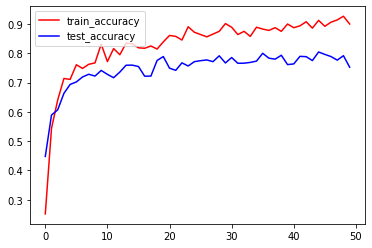

In [17]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

7. Do the same for your `loss`

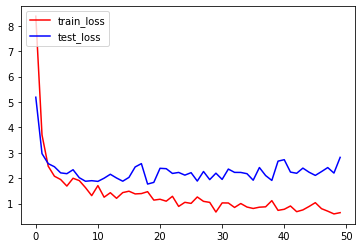

In [18]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# Fine-Tuning

1. Count the numbers of layers of your pre-trained model

In [19]:
len(base_model.layers)

311

2. Let about 10% of the layers towards the top in trainable status and freeze the rest. You will have to load the pre-trained model again.

In [23]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87916544/87910968 [==============================] - 1s 0us/step


In [24]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

3. Add some prediction layers to adapt the model to the problem at hand.

In [25]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(102, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               835686    
Total params: 22,638,470
Trainable params: 5,991,718
Non-trainable params: 16,646,752
_________________________________________________________________


4. Compile the model

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

5. Train the model using 20 steps per epochs and 50 epochs.

In [25]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50)

Epoch 1/50
20/20 [==============================] - 28s 1s/step - loss: 5.9801 - categorical_accuracy: 0.2762 - val_loss: 2.4960 - val_categorical_accuracy: 0.6100
Epoch 2/50
20/20 [==============================] - 21s 1s/step - loss: 1.7826 - categorical_accuracy: 0.6534 - val_loss: 1.7866 - val_categorical_accuracy: 0.6922
Epoch 3/50
20/20 [==============================] - 21s 1s/step - loss: 0.9795 - categorical_accuracy: 0.7430 - val_loss: 1.2355 - val_categorical_accuracy: 0.7596
Epoch 4/50
20/20 [==============================] - 21s 1s/step - loss: 0.8770 - categorical_accuracy: 0.8063 - val_loss: 1.1710 - val_categorical_accuracy: 0.7730
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 0.6165 - categorical_accuracy: 0.8339 - val_loss: 0.9001 - val_categorical_accuracy: 0.8096
Epoch 6/50
20/20 [==============================] - 23s 1s/step - loss: 0.4907 - categorical_accuracy: 0.8702 - val_loss: 0.9215 - val_categorical_accuracy: 0.8159
Epoch 7/50
20/20

In [26]:
model.save("/content/caltechFineTuningModel.h5")

In [6]:
import json

In [27]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/caltechFineTuningModelHistory.json", 'w'))

In [4]:
tf.keras.utils.get_file("/content/caltechFineTuningModelHistory.json",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechFineTuningModelHistory.json")

8192/3946 [==============================================================] - 0s 0us/step


'/content/caltechFineTuningModelHistory.json'

In [7]:
history_dict = json.load(open("/content/caltechFineTuningModelHistory.json", 'r'))

In [8]:
tf.keras.utils.get_file("/content/caltechFineTuningModel.h5",
                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechFineTuningModel.h5")

139051008/139045248 [==============================] - 18s 0us/step


'/content/caltechFineTuningModel.h5'

In [28]:
model = tf.keras.models.load_model("/content/caltechFineTuningModel.h5")

6. Visualize your `accuracy` on your `train` and on your `test` 

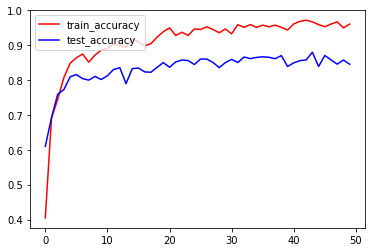

In [11]:
# Visualise train / Valid Accuracy
plt.plot(history_dict["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(history_dict["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

7. Do the same for your `loss`

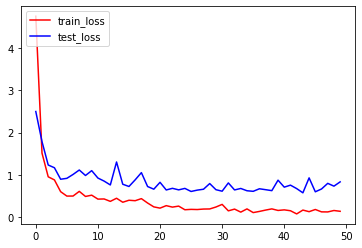

In [12]:
# Visualise train / Valid Loss
plt.plot(history_dict["loss"], c="r", label="train_loss")
plt.plot(history_dict["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# Interpretation with Grad Cam

1. Create an object `imgs` and an object `labels` containing a batch of validation images and validation labels.

In [18]:
imgs, labels = next(iter(img_generator_flow_valid))

2. Get the name of the last convolution layer of the pretrained model and the predicition layers and store them in two variables called respectively `last_conv_layer_name`, and `classifier_layer_names`. 

In [29]:
for layer in model.layers:
  print(layer.name)

inception_v3
max_pooling2d_9
flatten_1
dense_1


In [30]:
base_model = model.layers[0]

In [31]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
for layer in base_model.layers:
  print(layer.name)

input_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_5
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_6
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
activation

In [33]:
for layer in model.layers:
  print(layer.name)

inception_v3
max_pooling2d_9
flatten_1
dense_1


In [34]:
last_conv_layer_name = "mixed10"
classifier_layer_names = [layer.name for layer in model.layers][1:]

3. Run the following command, these functions will help you produce the grad cam

In [35]:
# We start by setting up the dependencies we will use

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [36]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

4. Create a `preds` object containing the predicitons from your model on the batch of validation images.

Then create a `pred_labels` object containing the top class predicted for each image in that batch. (You can use the `tf.argmax` function for this)

In [42]:
# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)

print("Predicted label:", pred_labels)

Prediction output: [[9.99981880e-01 3.35913057e-08 1.80326758e-08 ... 4.89522778e-09
  1.81663851e-11 1.00736675e-09]
 [1.28883171e-09 9.42009925e-12 2.49562680e-11 ... 6.07581180e-16
  3.85556949e-18 7.77452061e-12]
 [2.21016599e-05 1.08762538e-06 3.37381124e-07 ... 2.68365774e-08
  1.49250955e-05 1.02863794e-06]
 ...
 [1.39489236e-11 1.27131067e-13 7.32232764e-12 ... 5.95380729e-15
  2.50343586e-14 1.08625671e-10]
 [3.73856279e-09 5.49264023e-10 1.26453137e-09 ... 8.04510809e-13
  1.42786716e-14 2.03590053e-12]
 [1.78698321e-14 1.11404063e-16 2.01564952e-18 ... 5.32213656e-23
  3.21016653e-26 2.53526617e-21]]
Predicted label: tf.Tensor(
[ 0 52 62 78  0  0 81  2  2 95  4  6  3 55 60 42  1 64 64  7 36 72 33  0
 84  1  1  4 74 89 51 76], shape=(32,), dtype=int64)


5. For all the images in the validation batch use the `make_gradcam_heatmap` to create a grad cam heatmap and store them all in a list. Then display the first heatmap.

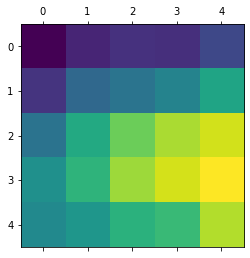

In [43]:
# Generate class activation heatmap
heatmaps = []

for img in imgs:
  heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),base_model, model, last_conv_layer_name, classifier_layer_names
  )
  heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()


6. Loop over each image, predicted label and heatmap in order to display the images with the superimposed grad cam heatmap and the corresponding predicted label. Do they match the true label? What happens to the grad cam for wrong predictions? Are there any grad cams that seem surprising to you?

In [46]:
from pathlib import Path

Predicted label: BACKGROUND_Google
True label: BACKGROUND_Google


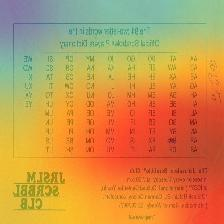

Predicted label: ibis
True label: ibis


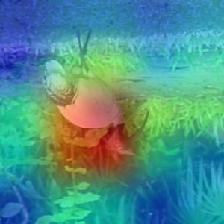

Predicted label: mandolin
True label: electric_guitar


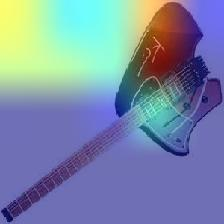

Predicted label: rooster
True label: rooster


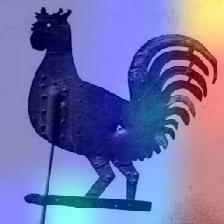

Predicted label: BACKGROUND_Google
True label: BACKGROUND_Google


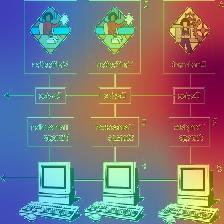

Predicted label: BACKGROUND_Google
True label: wrench


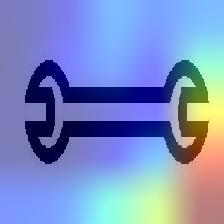

Predicted label: scissors
True label: scissors


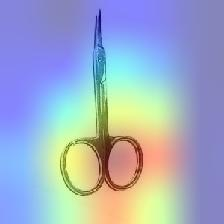

Predicted label: Faces_easy
True label: Faces_easy


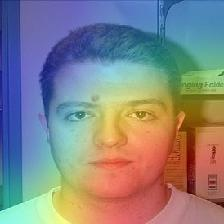

Predicted label: Faces_easy
True label: Faces_easy


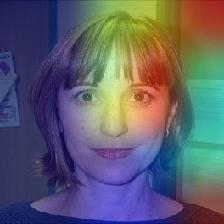

Predicted label: watch
True label: watch


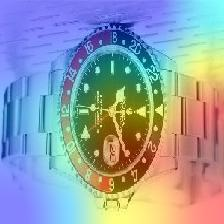

Predicted label: Motorbikes
True label: Motorbikes


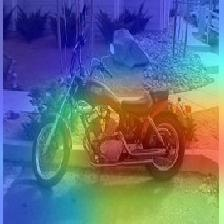

Predicted label: airplanes
True label: airplanes


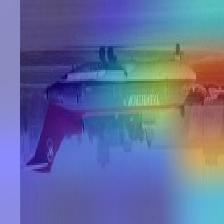

Predicted label: Leopards
True label: Leopards


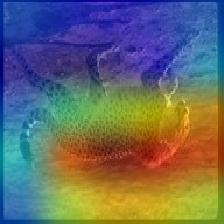

Predicted label: kangaroo
True label: kangaroo


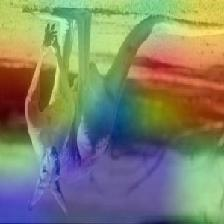

Predicted label: lobster
True label: crayfish


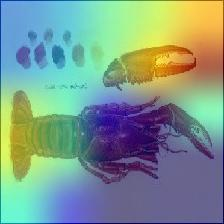

Predicted label: flamingo
True label: flamingo


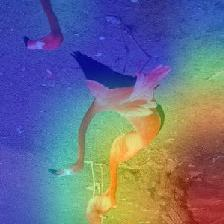

Predicted label: Faces
True label: Faces


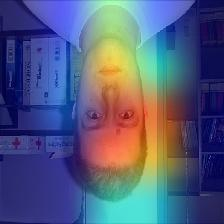

Predicted label: menorah
True label: menorah


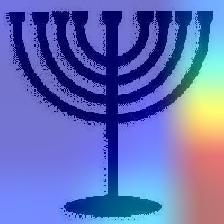

Predicted label: menorah
True label: menorah


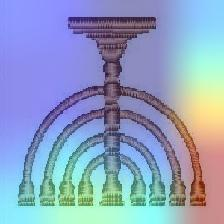

Predicted label: anchor
True label: anchor


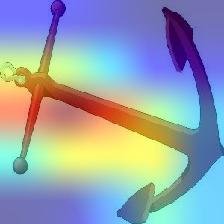

Predicted label: electric_guitar
True label: electric_guitar


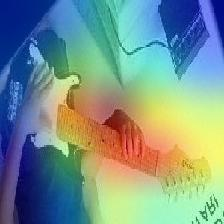

Predicted label: pigeon
True label: pigeon


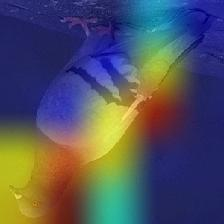

Predicted label: dollar_bill
True label: dollar_bill


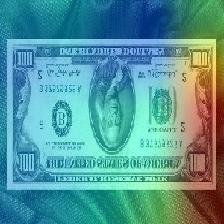

Predicted label: BACKGROUND_Google
True label: BACKGROUND_Google


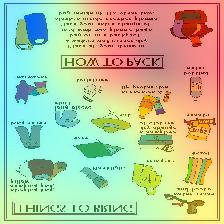

Predicted label: snoopy
True label: BACKGROUND_Google


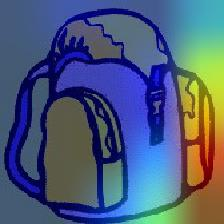

Predicted label: Faces
True label: Faces


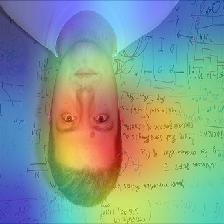

Predicted label: Faces
True label: Faces


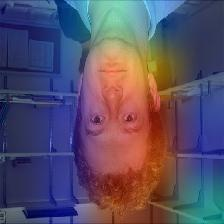

Predicted label: Motorbikes
True label: Motorbikes


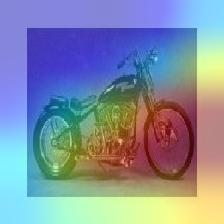

Predicted label: platypus
True label: kangaroo


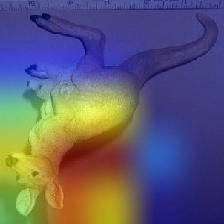

Predicted label: stop_sign
True label: stop_sign


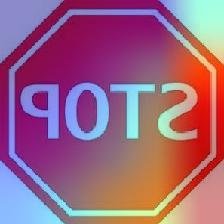

Predicted label: helicopter
True label: airplanes


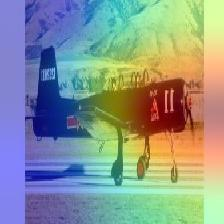

Predicted label: revolver
True label: revolver


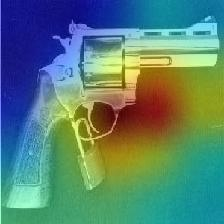

In [48]:
 for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps): 
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.003 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "saved_img.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  pred_file_path = np.argmax(img_generator_flow_valid.labels == pred_label)
  pred_label_name = Path(img_generator_flow_valid.filepaths[pred_file_path]).parent.name

  true_file_path = np.argmax(img_generator_flow_valid.labels == tf.argmax(true_label))
  true_label_name = Path(img_generator_flow_valid.filepaths[true_file_path]).parent.name

  print("Predicted label:",pred_label_name)
  print("True label:", true_label_name)

  display(Image(save_path))